Files already downloaded and verified
Files already downloaded and verified
ExampleModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

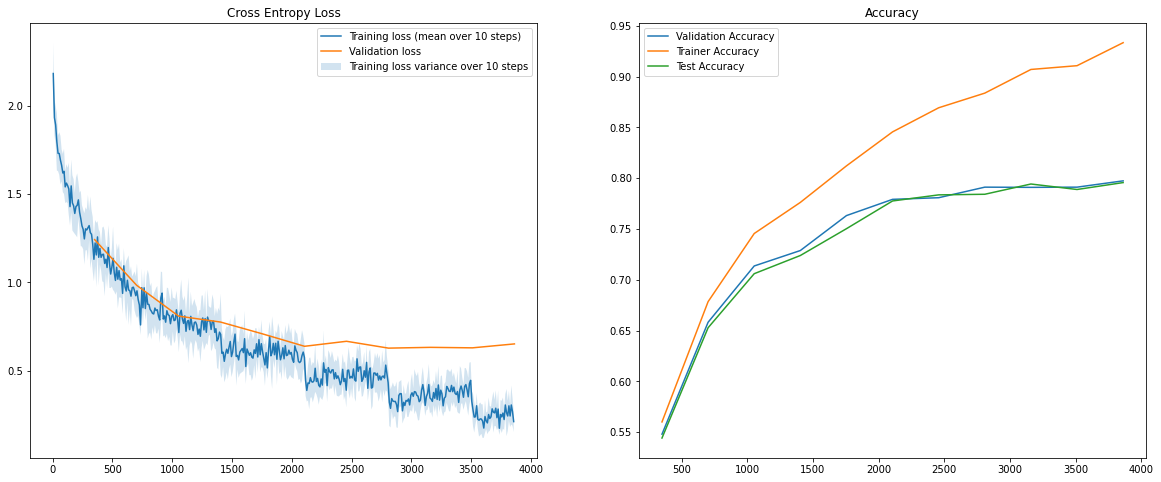

In [1]:
import pathlib
import matplotlib.pyplot as plt
import utils
from torch import nn
from dataloaders import load_cifar10
from trainer import Trainer, compute_loss_and_accuracy


class ExampleModel(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # TODO: Implement this function (Task  2a)
        num_filters = 32  # Set number of filters in first conv layer
        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential(
            #[32*32*3]
            nn.Conv2d(
                in_channels=image_channels,
                out_channels=num_filters,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            nn.Conv2d(
                in_channels=num_filters,
                out_channels=num_filters,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            nn.MaxPool2d(
               kernel_size=2,
               stride=2
            ),
            #nn.Dropout(p=0.2),
            
            #[16*16*32]
            nn.Conv2d(
                in_channels=num_filters,
                out_channels=64,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(
               kernel_size=2,
               stride=2
            ),
            #nn.Dropout(p=0.3),
            #[8*8*64]
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
            #nn.Dropout(p=0.4)
        )
        # The output of feature_extractor will be [batch_size, num_filters, 16, 16]
        self.num_output_features = 4*4*128
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            nn.Linear(self.num_output_features, 64),
            nn.ReLU(),
            #nn.Dropout(p=0.5),
            ##leakyRelu
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        out = self.feature_extractor(x)
        #flatten image
        out = out.view(-1, self.num_output_features)
        out = self.classifier(out)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


def create_plots(trainer: Trainer, name: str):
    plot_path = pathlib.Path("plots")
    plot_path.mkdir(exist_ok=True)
    # Save plots and show them
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title("Cross Entropy Loss")
    #loss for training and validation loss for best model 
    utils.plot_loss(trainer.train_history["loss"], label="Training loss", npoints_to_average=10)
    utils.plot_loss(trainer.validation_history["loss"], label="Validation loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    #plot validation accuracy that can be used for the best model, and for the further imporvement  
    utils.plot_loss(trainer.validation_history["accuracy"], label="Validation Accuracy")
    utils.plot_loss(trainer.train_history["accuracy"], label="Trainer Accuracy")
    utils.plot_loss(trainer.test_history["accuracy"], label="Test Accuracy")
    plt.legend()
    plt.savefig(plot_path.joinpath(f"{name}_plot.png"))
    plt.show() 

if __name__ == "__main__":
    # Set the random generator seed (parameters, shuffling etc).
    # You can try to change this and check if you still get the same result! 
    utils.set_seed(0)
    epochs = 10
    batch_size = 64
    learning_rate = 5e-2
    early_stop_count = 4
    dataloaders = load_cifar10(batch_size)
    model = ExampleModel(image_channels=3, num_classes=10)
    trainer = Trainer(
        batch_size,
        learning_rate,
        early_stop_count,
        epochs,
        model,
        dataloaders
    )
    trainer.train()
    create_plots(trainer, "task3_architecture")